# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install numpy==1.21

Note: you may need to restart the kernel to use updated packages.


In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
# всякие импорты
import numpy as np
import statistics
import math
np.random.seed(0) 
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [3]:
# функция для подсчета эвристики

def sigma_squared(x):
    new_dim = x.shape[1]
    rng = np.random.default_rng()
    sum = np.zeros(1000000)
    for i in range(new_dim):                    # прохожусь по всем столбцам в матрице
        first = rng.choice(x[:, i], 1000000)    # генерим миллион рандомных значений из столбца 
        second = rng.choice(x[:, i], 1000000)   # генерим еще миллион чтобы образовать пары
        diff = (first - second) ** 2
        sum += diff                             # суммируем столбцы
    sigma_2 = statistics.median(sum)
    return sigma_2 

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA: 
            self.pca = PCA(n_components = self.new_dim)
            self.pca.fit(X)
            X = self.pca.transform(X)
        sigma_2 = sigma_squared(X)
        self.w = np.random.normal(0, (1/math.sqrt(sigma_2)), size = (X.shape[1], self.n_features)) 
        self.b = np.random.uniform(-math.pi, math.pi, self.n_features)
        phi = np.cos(np.dot(X, self.w) + self.b)
        if self.classifier == "logreg":
            self.logreg = LogisticRegression(random_state=0)
            self.logreg.fit(phi, y)
        else:
            self.clf = LinearSVC(random_state=0)
            self.clf.fit(phi, y)
  
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        phi = np.cos(np.dot(X, self.w) + self.b)
        return predict_proba(phi)
            
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        phi = np.cos(np.dot(X, self.w) + self.b)
        if self.classifier == 'logreg': 
            
            return self.logreg.predict(phi)
        else: 
    
            return self.clf.predict(phi)
    

In [5]:
rff = RFFPipeline()
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
accuracy_score(y_test, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s finished


0.8584

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

Обучение на исходных признаках ядровым SVM оказалось более продуктивным: accuracy 0.88 и обучение всего 3.87 минуты. Но в то же время градиентный бустинг тоже показывает себя очень хорошо, по сравнению со случайными признаками. В принципе можно выбирать разные модели в зависимости от того, есть ли какие-то ограничения по времени: дольше всего работает RFF + linear SVM, при этом выдает не самое лучшее качество. Самый быстрый - бустинг, который выдал 0.85 за 0.27 секунды. Но по accuracy выигрывает kernel SVM на исходных данных и бустинг на исходных: по 0.88. Таким образом идея со случайными признаками хоть и работает, но не сильно то и помогает.

## kernel SVM на исходных

In [8]:
clf = SVC(random_state=0)
t1 = time.time()
clf.fit(x_train, y_train)
t2 = time.time()
print('моделька обучалась', (t2 - t1)/60, "минут")
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

[LibSVM]моделька обучалась 3.8658482829729715 минут


0.8828

## linear SVM  на исходных

In [10]:
clf = LinearSVC(random_state=0)
t1 = time.time()
clf.fit(x_train, y_train)
t2 = time.time()
print('моделька обучалась', (t2 - t1)/60, "минут")
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

моделька обучалась 3.959287710984548 минут


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8019

## PCA + RFF + linear SVM

In [6]:
rff = RFFPipeline(classifier='svm')
t1 = time.time()
rff.fit(x_train.astype(np.float64), y_train)
t2 = time.time()
print('моделька обучалась', (t2 - t1)/60, "минут")
y_pred = rff.predict(x_test)
accuracy_score(y_test, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


моделька обучалась 4.901317878564199 минут


0.8702

## RFF + linear SVM

In [7]:
rff = RFFPipeline(use_PCA=False, classifier='svm')
t1 = time.time()
rff.fit(x_train.astype(np.float64), y_train)
t2 = time.time()
print('моделька обучалась', (t2 - t1)/60, "минут")
y_pred = rff.predict(x_test)
accuracy_score(y_test, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


моделька обучалась 5.230402612686158 минут


0.8581

## PCA + RFF + logreg


In [5]:
rff = RFFPipeline()
t1 = time.time()
rff.fit(x_train, y_train)
t2 = time.time()
print('моделька обучалась', (t2 - t1)/60, "минут")
y_pred = rff.predict(x_test)
accuracy_score(y_test, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


моделька обучалась 0.37270432313283286 минут


0.8576

## RFF + logreg


In [8]:
rff = RFFPipeline(use_PCA=False)
t1 = time.time()
rff.fit(x_train.astype(np.float64), y_train)
t2 = time.time()
print('моделька обучалась', (t2 - t1)/60, "минут")
y_pred = rff.predict(x_test)
accuracy_score(y_test, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


моделька обучалась 0.6232046127319336 минут


0.8631

## Подбор параметров для бустинга

In [63]:
acc_xgb = []
for j in [10, 20, 50]: 
    for k in [10, 20, 50]:
        for i in [0.01, 0.1, 1]:
            
            bst = XGBClassifier(n_estimators=k, max_depth=j, learning_rate=i)
            t1 = time.time()
            bst.fit(x_train, y_train)
            t2 = time.time()
            preds = bst.predict(x_test)
            acc = accuracy_score(y_test, preds)
            print("lr:", i, 'max_depth:', j, 'n_estimators', k, 'accuracy: ', acc, 'моделька обучалась', round((t2 - t1), 2), "секунд")
            acc_xgb.append(acc)
            

lr: 0.01 max_depth: 10 n_estimators 10 accuracy:  0.8495 моделька обучалась 51.2 секунд
lr: 0.1 max_depth: 10 n_estimators 10 accuracy:  0.8636 моделька обучалась 50.13 секунд
lr: 1 max_depth: 10 n_estimators 10 accuracy:  0.8643 моделька обучалась 49.03 секунд
lr: 0.01 max_depth: 10 n_estimators 20 accuracy:  0.8567 моделька обучалась 100.73 секунд
lr: 0.1 max_depth: 10 n_estimators 20 accuracy:  0.8701 моделька обучалась 101.09 секунд
lr: 1 max_depth: 10 n_estimators 20 accuracy:  0.8736 моделька обучалась 91.88 секунд
lr: 0.01 max_depth: 10 n_estimators 50 accuracy:  0.8645 моделька обучалась 248.79 секунд
lr: 0.1 max_depth: 10 n_estimators 50 accuracy:  0.8812 моделька обучалась 247.05 секунд
lr: 1 max_depth: 10 n_estimators 50 accuracy:  0.8829 моделька обучалась 192.35 секунд
lr: 0.01 max_depth: 20 n_estimators 10 accuracy:  0.8522 моделька обучалась 98.94 секунд
lr: 0.1 max_depth: 20 n_estimators 10 accuracy:  0.8686 моделька обучалась 97.67 секунд
lr: 1 max_depth: 20 n_estimato

KeyboardInterrupt: 

Если честно мне стало лень ждать до конца но качество 0.8829 и так более чем достаточно c параметрами lr: 1 max_depth: 10 n_estimators: 50

## PCA + XGBoost

In [67]:
pca = PCA(n_components = 50)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
acc_xgb = []
for j in [10, 20, 50]: 
    for k in [10, 20, 50]:
        bst = XGBClassifier(n_estimators= j, max_depth=k, learning_rate=1)
        t1 = time.time()
        bst.fit(x_train_pca, y_train)
        t2 = time.time()
        acc = accuracy_score(y_test, preds)
        preds = bst.predict(x_test_pca)
        print('max_depth:', j, 'n_estimators', k, 'accuracy: ', acc, 'моделька обучалась', round((t2 - t1), 2), "секунд")


max_depth: 10 n_estimators 10 accuracy:  0.8601 моделька обучалась 15.79 секунд
max_depth: 10 n_estimators 20 accuracy:  0.8368 моделька обучалась 19.56 секунд
max_depth: 10 n_estimators 50 accuracy:  0.8419 моделька обучалась 20.79 секунд
max_depth: 20 n_estimators 10 accuracy:  0.8398 моделька обучалась 28.43 секунд
max_depth: 20 n_estimators 20 accuracy:  0.8482 моделька обучалась 32.22 секунд
max_depth: 20 n_estimators 50 accuracy:  0.848 моделька обучалась 32.73 секунд
max_depth: 50 n_estimators 10 accuracy:  0.8463 моделька обучалась 58.08 секунд
max_depth: 50 n_estimators 20 accuracy:  0.8576 моделька обучалась 60.0 секунд
max_depth: 50 n_estimators 50 accuracy:  0.8559 моделька обучалась 60.55 секунд


In [68]:
pca = PCA(n_components = 50)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
acc_xgb = []
for j in [1, 3, 5, 10]: 
    for k in [1, 3, 5, 10, 20, 50]:
        bst = XGBClassifier(n_estimators= j, max_depth=k, learning_rate=1)
        t1 = time.time()
        bst.fit(x_train_pca, y_train)
        t2 = time.time()
        acc = accuracy_score(y_test, preds)
        preds = bst.predict(x_test_pca)
        print('max_depth:', j, 'n_estimators', k, 'accuracy: ', acc, 'моделька обучалась', round((t2 - t1), 2), "секунд")

max_depth: 1 n_estimators 1 accuracy:  0.8549 моделька обучалась 0.27 секунд
max_depth: 1 n_estimators 3 accuracy:  0.5155 моделька обучалась 0.61 секунд
max_depth: 1 n_estimators 5 accuracy:  0.7173 моделька обучалась 0.95 секунд
max_depth: 1 n_estimators 10 accuracy:  0.7645 моделька обучалась 1.99 секунд
max_depth: 1 n_estimators 20 accuracy:  0.8077 моделька обучалась 2.73 секунд
max_depth: 1 n_estimators 50 accuracy:  0.8068 моделька обучалась 2.92 секунд
max_depth: 3 n_estimators 1 accuracy:  0.8065 моделька обучалась 0.58 секунд
max_depth: 3 n_estimators 3 accuracy:  0.6473 моделька обучалась 1.59 секунд
max_depth: 3 n_estimators 5 accuracy:  0.7524 моделька обучалась 2.64 секунд
max_depth: 3 n_estimators 10 accuracy:  0.792 моделька обучалась 5.42 секунд
max_depth: 3 n_estimators 20 accuracy:  0.8185 моделька обучалась 7.54 секунд
max_depth: 3 n_estimators 50 accuracy:  0.8198 моделька обучалась 8.31 секунд
max_depth: 5 n_estimators 1 accuracy:  0.8193 моделька обучалась 0.92 с

С PCA самый лучший вариант получился lr: 1, max_depth: 10 n_estimators 10 accuracy:  0.8601 моделька обучалась 15.79 секунд, но еще очень забавно, что тоже неплохой результат выдало lr: 1, max_depth: 1 n_estimators 1 accuracy:  0.8549, причем всего за 0.27 секунды)))

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1. В случае с линейным SVM  качество с PCA выросло: без PCA 0.8581, с PCA 0.8702. Время обучения сократилось с 5.23 до 4.9 минут. PCA помог! Однако для логистической регрессии PCA помог только со временем обучения: снизил с 0.62 до  0.37 минут. Но при этом качество модели упало: без PCA 0.8631, с PCA 0.8576.

In [24]:
acc_logreg = []
n_features_i = [10, 50, 100, 150, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
for i in n_features_i: 
    rff = RFFPipeline(n_features = i)
    rff.fit(x_train, y_train)
    y_pred = rff.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(acc)
    acc_logreg.append(acc)
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6309


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8104


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8361


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8418


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8522


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8563


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8589


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8598


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8622


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8602


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.859


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8624


In [21]:
acc_svm = []
for i in n_features_i: 
    rff = RFFPipeline(n_features = i, classifier='svm' )
    rff.fit(x_train, y_train)
    y_pred = rff.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(acc)
    acc_svm.append(acc)

0.5812
0.8036


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8444


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8543


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8669


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8683


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8714


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8619


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8796


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8755


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8795


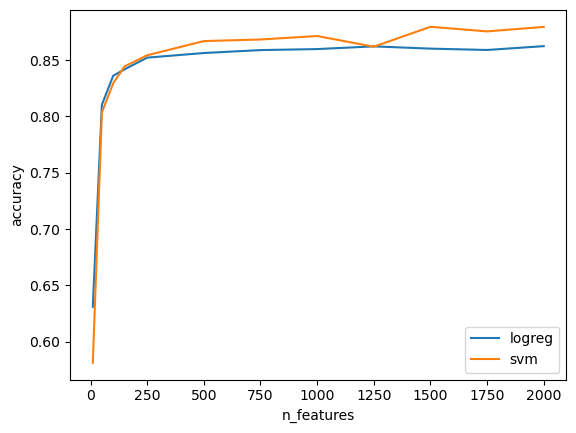

In [38]:
import matplotlib.pyplot as plt
plt.plot(n_features_i, acc_logreg, label = 'logreg')
plt.plot(n_features_i, acc_svm, label = 'svm')
plt.ylabel('accuracy')
plt.xlabel('n_features')
plt.legend()
plt.show()

2. Качество повышается с увеличением n_features, но выходит на плато примерно после n_features = 1000, svm выдает accuracy выше, чем логрег, но их поведение при увеличении количества features одинаковое.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪